In [14]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from scipy import stats

# Configure visualizations
plt.style.use('ggplot')
sns.set_theme(style="whitegrid")
%matplotlib inline
plt.rcParams["figure.figsize"] = (10,6)

In [15]:
# Load the clinical data and gene expression data
clinical_data = pd.read_csv('../Data/clinical.csv')
gene_data = pd.read_csv('../Data/patient_genes.csv')

# Display basic information about the datasets
print(f"Clinical data shape: {clinical_data.shape}")
print(f"Gene expression data shape: {gene_data.shape}")

Clinical data shape: (974, 115)
Gene expression data shape: (974, 19)


Distribution of TNBC vs non-TNBC cases and other relevant clinical features.

TNBC Distribution:
tnbc
False    860
True     114
Name: count, dtype: int64
Percentage of TNBC cases: 11.70%


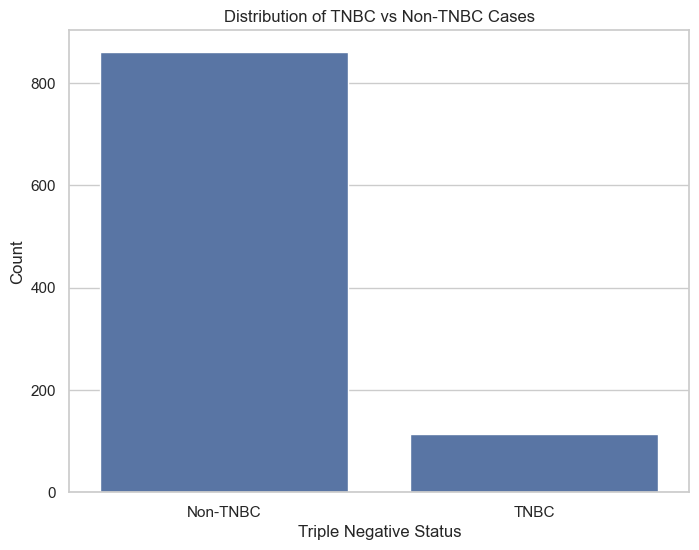

In [16]:
# Check TNBC distribution
tnbc_counts = clinical_data['tnbc'].value_counts()
print("TNBC Distribution:")
print(tnbc_counts)
print(f"Percentage of TNBC cases: {tnbc_counts[True]/len(clinical_data)*100:.2f}%")

# Visualize TNBC distribution
plt.figure(figsize=(8, 6))
sns.countplot(x='tnbc', data=clinical_data)
plt.title('Distribution of TNBC vs Non-TNBC Cases')
plt.xlabel('Triple Negative Status')
plt.xticks([0, 1], ['Non-TNBC', 'TNBC'])
plt.ylabel('Count')
plt.show()

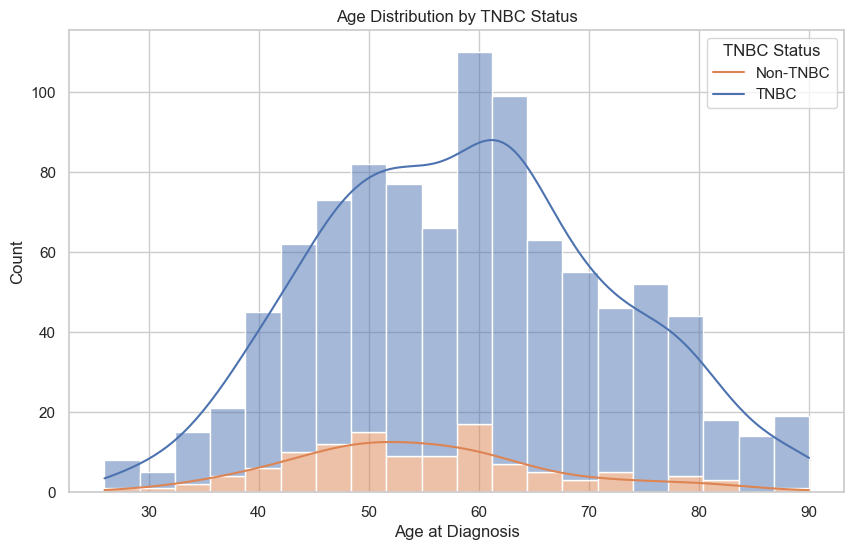

In [ ]:
# Examine patient demographics
# Age at diagnosis distribution by TNBC status
plt.figure(figsize=(10, 6))
sns.histplot(data=clinical_data, x='age_at_diagnosis', hue='tnbc',
             multiple='stack', bins=20, kde=True)
plt.title('Age Distribution by TNBC Status')
plt.xlabel('Age at Diagnosis')
plt.ylabel('Count')
plt.legend(title='TNBC Status', labels=['TNBC', 'Non-TNBC'])
plt.show()

Link gene expressions to differentiate between TNBC and non-TNBC samples.

In [18]:
# First, understand the structure of the gene expression data
print("Gene data columns (genes):")
print(gene_data.columns.tolist())

# Get basic statistics for each gene
gene_stats = gene_data.describe()
print("\nBasic statistics for gene expression values:")
gene_stats


Gene data columns (genes):
['CACNA2D2', 'ESR1', 'AGR2', 'GATA3', 'SLC16A6', 'TBC1D9', 'INPP4B', 'LDHB', 'MLPH', 'TSPAN1', 'STBD1', 'STARD3', 'RARA', 'MCCC2', 'PSAT1', 'MFGE8', 'ANXA9', 'PPP1R14C', 'SLC44A4']

Basic statistics for gene expression values:


,CACNA2D2,ESR1,AGR2,GATA3,SLC16A6,TBC1D9,INPP4B,LDHB,MLPH,TSPAN1,STBD1,STARD3,RARA,MCCC2,PSAT1,MFGE8,ANXA9,PPP1R14C,SLC44A4
count,974.000000,974.000000,974.000000,974.000000,974.000000,974.000000,974.000000,974.000000,974.000000,974.000000,974.000000,974.000000,974.000000,974.000000,974.000000,974.000000,974.000000,974.000000,974.000000
mean,799.901437,17583.154004,19863.422998,19344.055441,1445.093429,15383.268994,2337.943532,161.333676,11034.598563,3267.759754,52.288501,2709.876797,4233.373717,7194.740246,481.651951,5564.242300,1370.630390,239.941478,4350.337782
std,1001.082804,19408.068312,27865.199153,15414.235789,2899.536725,15788.423095,2264.491247,271.475737,9024.824630,4726.575058,34.903713,4867.133796,5190.730017,6246.649103,1277.879483,13788.790818,1241.875181,747.669398,3995.650928
min,9.000000,5.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,3.000000,3.000000,0.000000,0.000000,26.000000,0.000000,1.000000
25%,211.250000,3243.250000,3656.000000,8002.250000,211.250000,4408.250000,765.500000,42.000000,5164.750000,485.000000,29.000000,1046.750000,2093.500000,3050.750000,35.000000,1735.250000,429.000000,11.000000,1519.250000
50%,498.500000,11668.500000,10915.500000,17351.000000,551.000000,10753.500000,1725.500000,78.000000,9594.500000,1716.000000,44.500000,1448.500000,3344.500000,5525.500000,75.500000,2831.000000,1078.000000,33.000000,3525.500000
75%,986.750000,25799.500000,25063.500000,26494.750000,1412.500000,21980.500000,3060.000000,161.000000,15037.250000,4088.750000,64.000000,2019.250000,4848.250000,9396.250000,271.000000,4595.000000,1871.000000,105.000000,6296.250000
max,11058.000000,135639.000000,258700.000000,99070.000000,35088.000000,139823.000000,17138.000000,3152.000000,79774.000000,38905.000000,288.000000,67373.000000,111175.000000,63585.000000,19767.000000,241310.000000,10576.000000,11347.000000,43081.000000


In [19]:
# First check if gene_data has the same number of rows as clinical data
print(f"Gene data rows: {gene_data.shape[0]}")
print(f"Clinical data rows: {clinical_data.shape[0]}")

gene_data_with_status = gene_data.copy()
gene_data_with_status['tnbc'] = clinical_data['tnbc'].values

print("\nVerifying gene data with TNBC status:")
print(gene_data_with_status.shape)
gene_data_with_status.head()

Gene data rows: 974
Clinical data rows: 974

Verifying gene data with TNBC status:
(974, 20)


,CACNA2D2,ESR1,AGR2,GATA3,SLC16A6,TBC1D9,INPP4B,LDHB,MLPH,TSPAN1,STBD1,STARD3,RARA,MCCC2,PSAT1,MFGE8,ANXA9,PPP1R14C,SLC44A4,tnbc
0,2934,5459,2397,22694,533,28741,1411,77,9991,7790,226,1735,5474,7298,27,1338,4083,7,2522,False
1,1146,83,31977,7581,2621,2484,696,33,18941,1045,58,9801,1262,4188,515,2026,255,134,2266,False
2,179,4387,4988,6374,217,3038,559,42,3081,839,35,1467,7566,3067,124,1390,545,0,616,False
3,163,3242,19966,11680,1658,8178,4037,89,14805,2945,83,5490,3562,7924,42,2808,1426,57,5938,False
4,410,6934,8357,17783,862,6620,3515,50,8179,798,41,1595,3981,9489,93,4476,380,48,2005,False


## Differential Expression Analysis

Let's analyze whether there are significant differences in gene expression between TNBC and non-TNBC samples.

In [20]:
# Calculate mean expression for each gene by TNBC status
tnbc_means = gene_data_with_status[gene_data_with_status['tnbc'] == True].iloc[:, :-1].mean()
non_tnbc_means = gene_data_with_status[gene_data_with_status['tnbc'] == False].iloc[:, :-1].mean()

# Calculate fold change (log2)
fold_change = np.log2(tnbc_means / non_tnbc_means)

# Perform t-tests for each gene
p_values = []
for gene in gene_data.columns:
    tnbc_expr = gene_data_with_status[gene_data_with_status['tnbc'] == True][gene]
    non_tnbc_expr = gene_data_with_status[gene_data_with_status['tnbc'] == False][gene]
    _, p_value = stats.ttest_ind(tnbc_expr, non_tnbc_expr, equal_var=False)
    p_values.append(p_value)

# Create a DataFrame with the results
differential_expression = pd.DataFrame({
    'Gene': gene_data.columns,
    'TNBC_Mean': tnbc_means,
    'Non_TNBC_Mean': non_tnbc_means,
    'Log2_Fold_Change': fold_change,
    'P_Value': p_values
})

# Adjust p-values for multiple testing using Benjamini-Hochberg FDR method
from statsmodels.stats.multitest import fdrcorrection
_, adjusted_p_values = fdrcorrection(differential_expression['P_Value'])
differential_expression['Adjusted_P_Value'] = adjusted_p_values

# Sort by absolute fold change
differential_expression = differential_expression.sort_values(by='Log2_Fold_Change', key=abs, ascending=False)

print("Differential Expression Analysis:")
differential_expression

Differential Expression Analysis:


,Gene,TNBC_Mean,Non_TNBC_Mean,Log2_Fold_Change,P_Value,Adjusted_P_Value
ESR1,ESR1,440.622807,19855.536047,-5.493853,3.375594e-129,3.206815e-128
SLC16A6,SLC16A6,100.456140,1623.336047,-4.014324,2.342543e-43,4.046211e-43
TBC1D9,TBC1D9,1503.105263,17223.197674,-3.518335,5.079989e-126,3.217326e-125
AGR2,AGR2,1945.017544,22238.653488,-3.515214,3.937198e-40,6.233896e-40
MLPH,MLPH,1178.675439,12341.081395,-3.388230,1.293930e-119,6.146166e-119
PPP1R14C,PPP1R14C,1147.798246,119.597674,3.262608,2.978044e-13,3.328402e-13
GATA3,GATA3,2267.500000,21607.691860,-3.252371,2.395611e-139,4.551661e-138
PSAT1,PSAT1,2150.307018,260.458140,3.045419,1.531779e-16,1.940254e-16
TSPAN1,TSPAN1,441.526316,3642.400000,-3.044318,1.585139e-44,3.011764e-44
SLC44A4,SLC44A4,630.412281,4843.444186,-2.941666,1.068793e-55,2.538383e-55
